### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import T5Tokenizer, TFT5EncoderModel
import re
np.random.seed(42)
tf.random.set_seed(42)
import pickle
import sys
import gc
import os

Code for ProtBERT only

In [2]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

Changes from previous version: I am implementing COVID-19 classification with ProtTrans T5 BFD

In [3]:
embedding_model = TFT5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50", from_pt=True)

2022-12-31 12:15:10.171141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-31 12:15:10.171315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.6.layer.1.EncDecAttention.q.weight', 'decoder.block.16.layer.2.DenseReluDense.wi.weight', 'decoder.block.20.layer.1.EncDecAttention.o.weight', 'decoder.block.23.layer.1.EncDecAttention.v.weight', 'decoder.block.10.layer.0.SelfAttention.k.weight', 'decoder.block.21.layer.0.SelfAttention.q.weight', 'decoder.block.7.layer.1.EncDecAttention.q.weight', 'decoder.block.14.layer.2.layer_norm.weight', 'decoder.block.3.layer.2.DenseReluDense.wi.weight', 'decoder.block.19.layer.0.SelfAttention.o.weight', 'decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.11.layer.1.EncDecAttention.o.weight', 'decoder.block.6.layer.2.layer_norm.weight', 'decoder.block.10.layer.1.EncDecAttention.q.weight', 'decoder.block.19.layer.0.SelfAttention.k.weight', 'decoder.block.17.layer.0.layer_norm.weight', 'decoder.block.10.layer.0.SelfAtt

In [4]:
def get_embeddings(sequence_list):
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids).last_hidden_state)
    residue_embeddings = []
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        residues = embedding[seq_num][:seq_len-1]
        print(np.shape(residues))
        average = np.mean(residues, axis=0)

        residue_embeddings.append(residues)
        average_embeddings.append(average)

    print("Finished embeddings for this portion")

    return np.asarray(average_embeddings), residue_embeddings

In [5]:
sequences_Example = ["A E T C Z A O","S K T Z P"]

average_embeddings, residue_embeddings = get_embeddings(sequences_Example)

(7, 1024)
(5, 1024)
Finished embeddings for this portion


In [6]:
del average_embeddings
del residue_embeddings
gc.collect()

0

In [7]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [8]:
tf.__version__

'2.10.0'

# Data Formatting

In [9]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
5,QITLKESGPTLVKPTQTLTLTCKLSGFSVNTGGVGVGWIRQPPGKA...
32,QVQLVQSGAEVKKPGSSVKVSCKASGDTFNIYAINWVRQAPGQGLE...
33,QVQLVQSGAEVKKPGSSVKVSCKASGGTFNSYAITWVRQAPGQGLE...
34,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTHGMHWVRQAPGKGLE...
35,QVQLVQSGAEVKKPGSSVKVSCKASGGTFRRYAISWVRQAPGQGLE...
...,...
11862,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
11863,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
11864,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
11865,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [10]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11415:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11415


In [11]:
del head
del myfile
del dummy
gc.collect()

0

In [12]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [13]:
del df
gc.collect()

0

In [14]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [19]:
if os.path.exists('prot_t5_xl_uniref50_embeddings') == False:
    os.mkdir('prot_t5_xl_uniref50_embeddings')

In [20]:
for i in range(20):
    covid_sequences_new = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.05 * i):round(len(covid_sequences) * 0.05 * (i+1))]
    covid_average_embeddings, covid_residue_embeddings = get_embeddings(covid_sequences_new)

    with open("prot_t5_xl_uniref50_embeddings/covid_" + str(i) + ".pkl", "wb") as f:
        pickle.dump([covid_average_embeddings, covid_residue_embeddings], f)

    del covid_sequences_new
    del covid_average_embeddings
    del covid_residue_embeddings
    gc.collect()

(122, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(124, 1024)
(117, 1024)
(125, 1024)
(129, 1024)
(121, 1024)
(126, 1024)
(124, 1024)
(121, 1024)
(119, 1024)
(116, 1024)
(126, 1024)
(119, 1024)
(118, 1024)
(122, 1024)
(121, 1024)
(127, 1024)
(115, 1024)
(118, 1024)
(124, 1024)
(125, 1024)
(124, 1024)
(122, 1024)
(118, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(127, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(118, 1024)
(127, 1024)
(118, 1024)
(129, 1024)
(117, 1024)
(129, 1024)
(117, 1024)
(124, 1024)
(125, 1024)
(127, 1024)
(121, 1024)
(127, 1024)
(127, 1024)
(125, 1024)
(121, 1024)
(121, 1024)
(126, 1024)
(128, 1024)
(123, 1024)
(120, 1024)
(131, 1024)
(117, 1024)
(124, 1024)
(127, 1024)
(117, 1024)
(128, 1024)
(128, 1024)
(124, 1024)
(126, 1024)
(123, 1024)
(130, 1024)
(119, 1024)
(127, 1024)
(125, 1024)
(120, 1024)
(120, 1024)
(121, 1024)
(124, 1024)
(124, 1024)
(123, 1024)
(128, 1024)
(127, 1024)
(120, 1024)
(120, 1024)
(117, 1024)
(119, 1024)
(128, 1024)
(120

In [21]:
for i in range(20):
    healthy_sequences_new = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.05 * i):round(len(healthy_sequences) * 0.05 * (i+1))]
    healthy_average_embeddings, healthy_residue_embeddings = get_embeddings(healthy_sequences_new)

    with open("prot_t5_xl_uniref50_embeddings/healthy_" + str(i) + ".pkl", "wb") as f:
        pickle.dump([healthy_average_embeddings, healthy_residue_embeddings], f)

    del healthy_sequences_new
    del healthy_average_embeddings
    del healthy_residue_embeddings
    gc.collect()

(123, 1024)
(106, 1024)
(119, 1024)
(100, 1024)
(111, 1024)
(108, 1024)
(121, 1024)
(101, 1024)
(120, 1024)
(107, 1024)
(120, 1024)
(111, 1024)
(107, 1024)
(133, 1024)
(125, 1024)
(102, 1024)
(127, 1024)
(103, 1024)
(124, 1024)
(118, 1024)
(125, 1024)
(106, 1024)
(119, 1024)
(112, 1024)
(103, 1024)
(110, 1024)
(102, 1024)
(106, 1024)
(106, 1024)
(107, 1024)
(113, 1024)
(104, 1024)
(116, 1024)
(124, 1024)
(121, 1024)
(103, 1024)
(121, 1024)
(103, 1024)
(123, 1024)
(117, 1024)
(108, 1024)
(120, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(122, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(103, 1024)
(125, 1024)
(109, 1024)
(105, 1024)
(122, 1024)
(120, 1024)
(109, 1024)
(107, 1024)
(121, 1024)
(101, 1024)
(105, 1024)
(114, 1024)
(121, 1024)
(121, 1024)
(111, 1024)
(102, 1024)
(124, 1024)
(104, 1024)
(116, 1024)
(115, 1024)
(106, 1024)
(121, 1024)
(123, 1024)
(109, 1024)
(120, 1024)
(102, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(124, 1024)
(121, 1024)
(123

### Old Stuff

In [16]:
covid_sequences_1 = [(" ".join(s)) for s in covid_sequences][:round(len(covid_sequences) * 0.05)]
covid_sequences_2 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.3):round(len(covid_sequences) * 0.6)]
covid_sequences_3 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.6):round(len(covid_sequences) * 0.9)]
covid_sequences_4 = [(" ".join(s)) for s in covid_sequences][round(len(covid_sequences) * 0.9):]

In [17]:
covid_average_embeddings_1, covid_residue_embeddings_1 = get_embeddings(covid_sequences_1)

(122, 1024)
88 88 

(120, 1024)
88 88 

(122, 1024)
88 88 

(120, 1024)
88 88 

(124, 1024)
120 120 

(117, 1024)
120 120 

(125, 1024)
120 120 

(129, 1024)
120 120 

(121, 1024)
184 184 

(126, 1024)
184 184 

(124, 1024)
184 184 

(121, 1024)
184 184 

(119, 1024)
184 184 

(116, 1024)
184 184 

(126, 1024)
184 184 

(119, 1024)
184 184 

(118, 1024)
248 248 

(122, 1024)
248 248 

(121, 1024)
248 248 

(127, 1024)
248 248 

(115, 1024)
248 248 

(118, 1024)
248 248 

(124, 1024)
248 248 

(125, 1024)
248 248 

(124, 1024)
312 312 

(122, 1024)
312 312 

(118, 1024)
312 312 

(122, 1024)
312 312 

(121, 1024)
312 312 

(121, 1024)
312 312 

(121, 1024)
312 312 

(123, 1024)
312 312 

(127, 1024)
376 376 

(122, 1024)
376 376 

(121, 1024)
376 376 

(121, 1024)
376 376 

(118, 1024)
376 376 

(127, 1024)
376 376 

(118, 1024)
376 376 

(129, 1024)
376 376 

(117, 1024)
472 472 

(129, 1024)
472 472 

(117, 1024)
472 472 

(124, 1024)
472 472 

(125, 1024)
472 472 

(127, 1024)
472 47

In [18]:
with open("prot_t5_xl_uniref50_embeddings/covid_1.pkl", "wb") as f:
    pickle.dump([covid_average_embeddings_1, covid_residue_embeddings_1], f)

del covid_sequences_1
del covid_average_embeddings_1
del covid_residue_embeddings_1
gc.collect()

164

In [21]:
covid_average_embeddings_2, covid_residue_embeddings_2 = get_embeddings(covid_sequences_2)

(121, 1024)
(121, 1024)
(136, 1024)
(120, 1024)
(124, 1024)
(120, 1024)
(111, 1024)
(124, 1024)
(123, 1024)
(124, 1024)
(125, 1024)
(123, 1024)
(118, 1024)
(127, 1024)
(130, 1024)
(122, 1024)
(121, 1024)
(126, 1024)
(131, 1024)
(123, 1024)
(120, 1024)
(116, 1024)
(127, 1024)
(120, 1024)
(124, 1024)
(123, 1024)
(120, 1024)
(128, 1024)
(120, 1024)
(122, 1024)
(118, 1024)
(127, 1024)
(127, 1024)
(125, 1024)
(127, 1024)
(123, 1024)
(121, 1024)
(117, 1024)
(121, 1024)
(121, 1024)
(132, 1024)
(125, 1024)
(119, 1024)
(120, 1024)
(117, 1024)
(127, 1024)
(123, 1024)
(126, 1024)
(121, 1024)
(122, 1024)
(123, 1024)
(122, 1024)
(122, 1024)
(122, 1024)
(119, 1024)
(123, 1024)
(127, 1024)
(120, 1024)
(129, 1024)
(123, 1024)
(123, 1024)
(117, 1024)
(130, 1024)
(128, 1024)
(122, 1024)
(123, 1024)
(123, 1024)
(123, 1024)
(124, 1024)
(124, 1024)
(125, 1024)
(120, 1024)
(117, 1024)
(124, 1024)
(123, 1024)
(130, 1024)
(121, 1024)
(130, 1024)
(125, 1024)
(121, 1024)
(119, 1024)
(134, 1024)
(119, 1024)
(118

In [22]:
with open("prot_t5_xl_uniref50_embeddings/covid_2.pkl", "wb") as f:
    pickle.dump([covid_average_embeddings_2, covid_residue_embeddings_2], f)

del covid_sequences_2
del covid_average_embeddings_2
del covid_residue_embeddings_2
gc.collect()

0

In [23]:
covid_average_embeddings_3, covid_residue_embeddings_3 = get_embeddings(covid_sequences_3)

(122, 1024)
(116, 1024)
(124, 1024)
(115, 1024)
(128, 1024)
(122, 1024)
(119, 1024)
(123, 1024)
(128, 1024)
(118, 1024)
(125, 1024)
(119, 1024)
(122, 1024)
(122, 1024)
(125, 1024)
(128, 1024)
(127, 1024)
(117, 1024)
(120, 1024)
(119, 1024)
(128, 1024)
(118, 1024)
(129, 1024)
(127, 1024)
(128, 1024)
(121, 1024)
(117, 1024)
(122, 1024)
(124, 1024)
(120, 1024)
(123, 1024)
(123, 1024)
(123, 1024)
(120, 1024)
(127, 1024)
(128, 1024)
(122, 1024)
(125, 1024)
(128, 1024)
(127, 1024)
(124, 1024)
(123, 1024)
(124, 1024)
(123, 1024)
(130, 1024)
(126, 1024)
(121, 1024)
(124, 1024)
(120, 1024)
(123, 1024)
(121, 1024)
(124, 1024)
(117, 1024)
(125, 1024)
(129, 1024)
(122, 1024)
(120, 1024)
(120, 1024)
(124, 1024)
(122, 1024)
(126, 1024)
(118, 1024)
(125, 1024)
(127, 1024)
(129, 1024)
(129, 1024)
(130, 1024)
(120, 1024)
(121, 1024)
(127, 1024)
(123, 1024)
(127, 1024)
(120, 1024)
(121, 1024)
(123, 1024)
(133, 1024)
(124, 1024)
(118, 1024)
(130, 1024)
(123, 1024)
(126, 1024)
(120, 1024)
(120, 1024)
(126

In [24]:
with open("prot_t5_xl_uniref50_embeddings/covid_3.pkl", "wb") as f:
    pickle.dump([covid_average_embeddings_3, covid_residue_embeddings_3], f)

del covid_sequences_3
del covid_average_embeddings_3
del covid_residue_embeddings_3
gc.collect()

0

In [25]:
covid_average_embeddings_4, covid_residue_embeddings_4 = get_embeddings(covid_sequences_4)

(129, 1024)
(127, 1024)
(122, 1024)
(116, 1024)
(116, 1024)
(117, 1024)
(119, 1024)
(126, 1024)
(116, 1024)
(120, 1024)
(116, 1024)
(123, 1024)
(119, 1024)
(128, 1024)
(128, 1024)
(128, 1024)
(125, 1024)
(123, 1024)
(125, 1024)
(128, 1024)
(127, 1024)
(126, 1024)
(121, 1024)
(118, 1024)
(127, 1024)
(123, 1024)
(116, 1024)
(126, 1024)
(121, 1024)
(126, 1024)
(122, 1024)
(125, 1024)
(119, 1024)
(120, 1024)
(122, 1024)
(125, 1024)
(125, 1024)
(121, 1024)
(124, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(126, 1024)
(128, 1024)
(122, 1024)
(128, 1024)
(124, 1024)
(127, 1024)
(120, 1024)
(124, 1024)
(126, 1024)
(122, 1024)
(121, 1024)
(122, 1024)
(121, 1024)
(124, 1024)
(120, 1024)
(125, 1024)
(125, 1024)
(130, 1024)
(121, 1024)
(123, 1024)
(120, 1024)
(123, 1024)
(125, 1024)
(122, 1024)
(128, 1024)
(122, 1024)
(119, 1024)
(117, 1024)
(120, 1024)
(126, 1024)
(115, 1024)
(122, 1024)
(122, 1024)
(127, 1024)
(117, 1024)
(119, 1024)
(120, 1024)
(128, 1024)
(125, 1024)
(121, 1024)
(128

In [26]:
with open("prot_t5_xl_uniref50_embeddings/covid_4.pkl", "wb") as f:
    pickle.dump([covid_average_embeddings_4, covid_residue_embeddings_4], f)

del covid_sequences_4
del covid_average_embeddings_4
del covid_residue_embeddings_4
gc.collect()

0

In [27]:
# covid_cls_embeddings = np.concatenate(covid_cls_embeddings_1, covid_cls_embeddings_2, covid_cls_embeddings_3, covid_cls_embeddings_4)
# covid_average_embeddings = np.concatenate(covid_average_embeddings_1, covid_average_embeddings_2, covid_average_embeddings_3, covid_average_embeddings_4)
# covid_residue_embeddings = covid_residue_embeddings_1 + covid_residue_embeddings_2 + covid_residue_embeddings_3 + covid_residue_embeddings_4

In [28]:
healthy_sequences_1 = [(" ".join(s)) for s in healthy_sequences][:round(len(healthy_sequences) * 0.3)]
healthy_sequences_2 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.3):round(len(healthy_sequences) * 0.6)]
healthy_sequences_3 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.6):round(len(healthy_sequences) * 0.9)]
healthy_sequences_4 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.9):]

In [29]:
healthy_average_embeddings_1, healthy_residue_embeddings_1 = get_embeddings(healthy_sequences_1)

(123, 1024)
(106, 1024)
(119, 1024)
(100, 1024)
(111, 1024)
(108, 1024)
(121, 1024)
(101, 1024)
(120, 1024)
(107, 1024)
(120, 1024)
(111, 1024)
(107, 1024)
(133, 1024)
(125, 1024)
(102, 1024)
(127, 1024)
(103, 1024)
(124, 1024)
(118, 1024)
(125, 1024)
(106, 1024)
(119, 1024)
(112, 1024)
(103, 1024)
(110, 1024)
(102, 1024)
(106, 1024)
(106, 1024)
(107, 1024)
(113, 1024)
(104, 1024)
(116, 1024)
(124, 1024)
(121, 1024)
(103, 1024)
(121, 1024)
(103, 1024)
(123, 1024)
(117, 1024)
(108, 1024)
(120, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(122, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(103, 1024)
(125, 1024)
(109, 1024)
(105, 1024)
(122, 1024)
(120, 1024)
(109, 1024)
(107, 1024)
(121, 1024)
(101, 1024)
(105, 1024)
(114, 1024)
(121, 1024)
(121, 1024)
(111, 1024)
(102, 1024)
(124, 1024)
(104, 1024)
(116, 1024)
(115, 1024)
(106, 1024)
(121, 1024)
(123, 1024)
(109, 1024)
(120, 1024)
(102, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(124, 1024)
(121, 1024)
(123

In [30]:
with open("prot_t5_xl_uniref50_embeddings/healthy_1.pkl", "wb") as f:
    pickle.dump([healthy_average_embeddings_1, healthy_residue_embeddings_1], f)

del healthy_sequences_1
del healthy_average_embeddings_1
del healthy_residue_embeddings_1
gc.collect()

0

In [31]:
healthy_average_embeddings_2, healthy_residue_embeddings_2 = get_embeddings(healthy_sequences_2)

(115, 1024)
(126, 1024)
(125, 1024)
(127, 1024)
(125, 1024)
(118, 1024)
(121, 1024)
(124, 1024)
(104, 1024)
(127, 1024)
(120, 1024)
(127, 1024)
(115, 1024)
(128, 1024)
(104, 1024)
(119, 1024)
(124, 1024)
(127, 1024)
(105, 1024)
(118, 1024)
(124, 1024)
(117, 1024)
(116, 1024)
(106, 1024)
(106, 1024)
(124, 1024)
(121, 1024)
(120, 1024)
(118, 1024)
(124, 1024)
(121, 1024)
(121, 1024)
(122, 1024)
(106, 1024)
(123, 1024)
(117, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(109, 1024)
(118, 1024)
(127, 1024)
(125, 1024)
(122, 1024)
(116, 1024)
(121, 1024)
(100, 1024)
(113, 1024)
(125, 1024)
(118, 1024)
(124, 1024)
(104, 1024)
(109, 1024)
(128, 1024)
(125, 1024)
(120, 1024)
(118, 1024)
(104, 1024)
(122, 1024)
(105, 1024)
(110, 1024)
(107, 1024)
(101, 1024)
(121, 1024)
(124, 1024)
(103, 1024)
(118, 1024)
(121, 1024)
(121, 1024)
(128, 1024)
(103, 1024)
(107, 1024)
(104, 1024)
(126, 1024)
(107, 1024)
(123, 1024)
(124, 1024)
(103, 1024)
(111, 1024)
(126, 1024)
(111, 1024)
(111, 1024)
(119, 1024)
(124

In [32]:
with open("prot_t5_xl_uniref50_embeddings/healthy_2.pkl", "wb") as f:
    pickle.dump([healthy_average_embeddings_2, healthy_residue_embeddings_2], f)

del healthy_sequences_2
del healthy_average_embeddings_2
del healthy_residue_embeddings_2
gc.collect()

0

In [33]:
healthy_average_embeddings_3, healthy_residue_embeddings_3 = get_embeddings(healthy_sequences_3)

(124, 1024)
(117, 1024)
(114, 1024)
(128, 1024)
(108, 1024)
(108, 1024)
(102, 1024)
(129, 1024)
(101, 1024)
(104, 1024)
(124, 1024)
(124, 1024)
(101, 1024)
(110, 1024)
(120, 1024)
(107, 1024)
(103, 1024)
(116, 1024)
(107, 1024)
(107, 1024)
(116, 1024)
(126, 1024)
(124, 1024)
(109, 1024)
(108, 1024)
(108, 1024)
(119, 1024)
(115, 1024)
(125, 1024)
(121, 1024)
(120, 1024)
(107, 1024)
(116, 1024)
(107, 1024)
(119, 1024)
(109, 1024)
(110, 1024)
(123, 1024)
(103, 1024)
(105, 1024)
(102, 1024)
(103, 1024)
(115, 1024)
(127, 1024)
(126, 1024)
(104, 1024)
(103, 1024)
(115, 1024)
(126, 1024)
(124, 1024)
(103, 1024)
(111, 1024)
(115, 1024)
(125, 1024)
(103, 1024)
(106, 1024)
(104, 1024)
(105, 1024)
(124, 1024)
(111, 1024)
(120, 1024)
(102, 1024)
(102, 1024)
(122, 1024)
(122, 1024)
(117, 1024)
(120, 1024)
(109, 1024)
(123, 1024)
(104, 1024)
(120, 1024)
(128, 1024)
(126, 1024)
(120, 1024)
(106, 1024)
(123, 1024)
(124, 1024)
(122, 1024)
(115, 1024)
(106, 1024)
(118, 1024)
(121, 1024)
(103, 1024)
(121

In [34]:
with open("prot_t5_xl_uniref50_embeddings/healthy_3.pkl", "wb") as f:
    pickle.dump([healthy_average_embeddings_3, healthy_residue_embeddings_3], f)

del healthy_sequences_3
del healthy_average_embeddings_3
del healthy_residue_embeddings_3
gc.collect()

0

In [35]:
healthy_average_embeddings_4, healthy_residue_embeddings_4 = get_embeddings(healthy_sequences_4)

(110, 1024)
(124, 1024)
(121, 1024)
(110, 1024)
(120, 1024)
(104, 1024)
(100, 1024)
(107, 1024)
(101, 1024)
(118, 1024)
(115, 1024)
(120, 1024)
(125, 1024)
(123, 1024)
(125, 1024)
(109, 1024)
(114, 1024)
(106, 1024)
(111, 1024)
(121, 1024)
(102, 1024)
(115, 1024)
(122, 1024)
(107, 1024)
(110, 1024)
(102, 1024)
(110, 1024)
(129, 1024)
(126, 1024)
(112, 1024)
(103, 1024)
(106, 1024)
(114, 1024)
(102, 1024)
(105, 1024)
(107, 1024)
(107, 1024)
(113, 1024)
(115, 1024)
(103, 1024)
(103, 1024)
(114, 1024)
(121, 1024)
(126, 1024)
(107, 1024)
(121, 1024)
(115, 1024)
(107, 1024)
(106, 1024)
(123, 1024)
(110, 1024)
(108, 1024)
(101, 1024)
(109, 1024)
(119, 1024)
(106, 1024)
(107, 1024)
(132, 1024)
(124, 1024)
(123, 1024)
(117, 1024)
(123, 1024)
(120, 1024)
(124, 1024)
(108, 1024)
(117, 1024)
(122, 1024)
(122, 1024)
(118, 1024)
(113, 1024)
(107, 1024)
(101, 1024)
(110, 1024)
(105, 1024)
(119, 1024)
(122, 1024)
(103, 1024)
(105, 1024)
(102, 1024)
(114, 1024)
(107, 1024)
(117, 1024)
(105, 1024)
(116

In [36]:
with open("prot_t5_xl_uniref50_embeddings/healthy_4.pkl", "wb") as f:
    pickle.dump([healthy_average_embeddings_4, healthy_residue_embeddings_4], f)

del healthy_sequences_4
del healthy_average_embeddings_4
del healthy_residue_embeddings_4
gc.collect()

0

# Loading

In [2]:
covid_average_embeddings = [[None] * 1024]
covid_residue_embeddings = []

In [3]:
for i in range(20):
    with open("prot_t5_xl_uniref50_embeddings/covid_" + str(i) + ".pkl", "rb") as f:
        covid_temp = pickle.load(f)
        covid_average_embeddings = np.concatenate((covid_average_embeddings, covid_temp[0]))
        for j in covid_temp[1]:
            covid_residue_embeddings.append(j)
    f.close()

covid_average_embeddings = np.delete(covid_average_embeddings, 0, 0)

In [4]:
print(covid_residue_embeddings[0].shape)

(122, 1024)


In [5]:
healthy_average_embeddings = [[None] * 1024]
healthy_residue_embeddings = []

In [6]:
for i in range(20):

    with open("prot_t5_xl_uniref50_embeddings/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp[0]))
        for j in healthy_temp[1]:
            healthy_residue_embeddings.append(j)
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [7]:
print(healthy_average_embeddings.shape)

(11415, 1024)


In [8]:
global_maxlen = 138 # this needs to be known a priori, from the max aa length block earlier

def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    Z = np.zeros((len(M), global_maxlen, 1024))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] = row 
    return Z

In [9]:
covid_residue_embeddings = pad_to_dense(covid_residue_embeddings)
healthy_residue_embeddings = pad_to_dense(healthy_residue_embeddings)

In [10]:
healthy_lables = [0] * 11415
covid_lables = [1] * 11415

# Model 1: Residues (2D) (Change this to a CNN)

In [11]:
X = np.concatenate((healthy_residue_embeddings, covid_residue_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [12]:
del healthy_residue_embeddings
del covid_residue_embeddings
gc.collect()

0

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
del X
del y
gc.collect()

0

In [15]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(138, 1024)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2022-12-31 15:04:11.398017: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-31 15:04:11.398661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 141312)            0         
                                                                 
 dense (Dense)               (None, 1024)              144704512 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                        

In [16]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, epochs=25, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/25


2022-12-31 15:04:37.063709: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-31 15:04:38.022370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.5347

2022-12-31 15:05:31.024300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 58s 98ms/step - loss: 0.7377 - accuracy: 0.5347 - val_loss: 0.4846 - val_accuracy: 0.7479
Epoch 2/25
578/578 [==============================] - 52s 90ms/step - loss: 0.6587 - accuracy: 0.5424 - val_loss: 0.4569 - val_accuracy: 0.7406
Epoch 3/25
578/578 [==============================] - 52s 90ms/step - loss: 0.6492 - accuracy: 0.5466 - val_loss: 0.4461 - val_accuracy: 0.7562
Epoch 4/25
578/578 [==============================] - 52s 90ms/step - loss: 0.6442 - accuracy: 0.5510 - val_loss: 0.4607 - val_accuracy: 0.7586
Epoch 5/25
578/578 [==============================] - 52s 90ms/step - loss: 0.6475 - accuracy: 0.5501 - val_loss: 0.4539 - val_accuracy: 0.7766
Epoch 6/25
578/578 [==============================] - 53s 91ms/step - loss: 0.6358 - accuracy: 0.5578 - val_loss: 0.4204 - val_accuracy: 0.7771
Epoch 7/25
578/578 [==============================] - 52s 91ms/step - loss: 0.6311 - accuracy: 0.5612 - val_loss: 0.4123 - val_accuracy: 0.7864
Epo

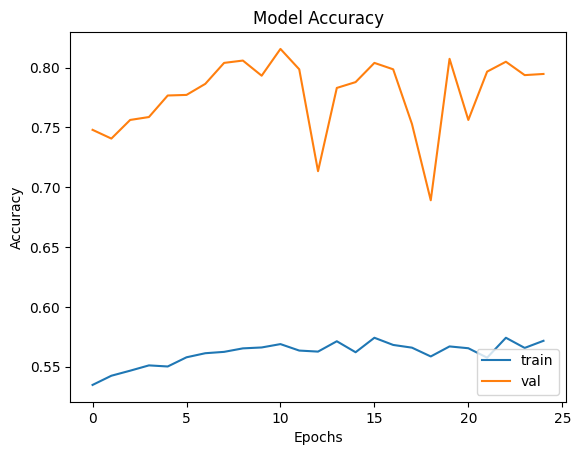

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 1 Testing

In [19]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 5s 57ms/step - loss: 0.4639 - accuracy: 0.7994


[0.4639322757720947, 0.7993867993354797]

In [20]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 19ms/step


2022-12-31 15:26:47.089948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 39ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

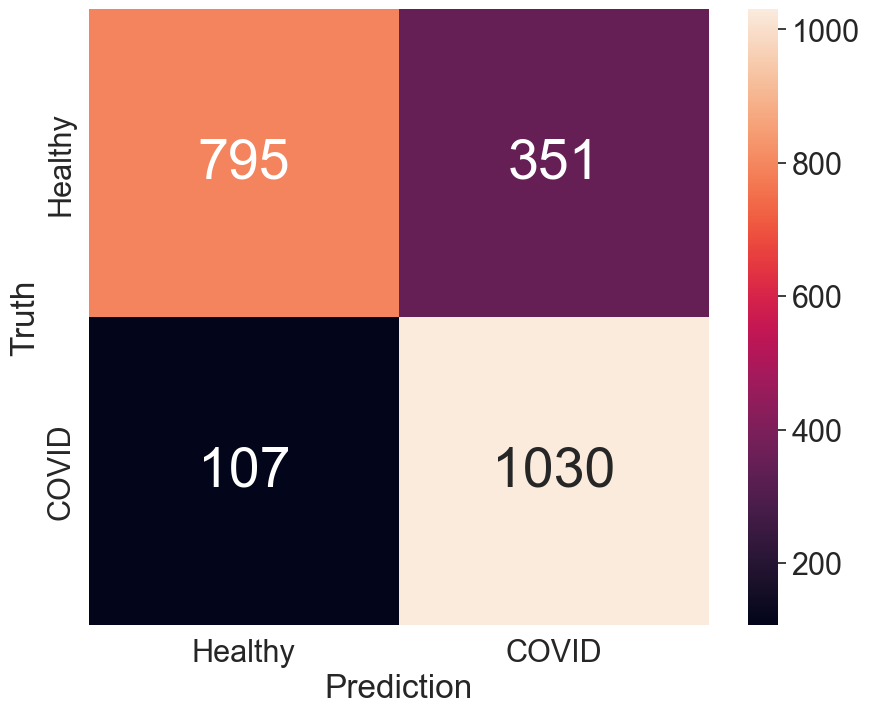

tf.Tensor(
[[ 795  351]
 [ 107 1030]], shape=(2, 2), dtype=int32)


In [21]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [22]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

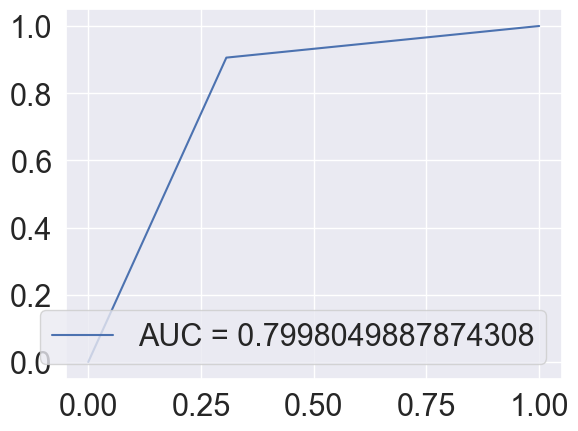

In [23]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()

# Model 3: Averaging Embeddings

In [24]:
X = np.concatenate((healthy_average_embeddings, covid_average_embeddings))
y = np.concatenate((healthy_lables, covid_lables))

In [25]:
del healthy_average_embeddings
del covid_average_embeddings
gc.collect()

39121

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [27]:
del X
del y
gc.collect()

0

In [28]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [29]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_9 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [30]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='auto',
    restore_best_weights=True,
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/100


2022-12-31 15:29:10.561184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.6302

2022-12-31 15:29:20.275173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 11s 17ms/step - loss: 0.6082 - accuracy: 0.6302 - val_loss: 0.5642 - val_accuracy: 0.6881
Epoch 2/100
578/578 [==============================] - 9s 16ms/step - loss: 0.5370 - accuracy: 0.7100 - val_loss: 0.5254 - val_accuracy: 0.7163
Epoch 3/100
578/578 [==============================] - 9s 15ms/step - loss: 0.5173 - accuracy: 0.7260 - val_loss: 0.5100 - val_accuracy: 0.7285
Epoch 4/100
578/578 [==============================] - 9s 15ms/step - loss: 0.4936 - accuracy: 0.7356 - val_loss: 0.4788 - val_accuracy: 0.7489
Epoch 5/100
578/578 [==============================] - 9s 15ms/step - loss: 0.4720 - accuracy: 0.7538 - val_loss: 0.4752 - val_accuracy: 0.7474
Epoch 6/100
578/578 [==============================] - 9s 15ms/step - loss: 0.4569 - accuracy: 0.7661 - val_loss: 0.4627 - val_accuracy: 0.7416
Epoch 7/100
578/578 [==============================] - 8s 14ms/step - loss: 0.4471 - accuracy: 0.7708 - val_loss: 0.4706 - val_accuracy: 0.7436
Epo

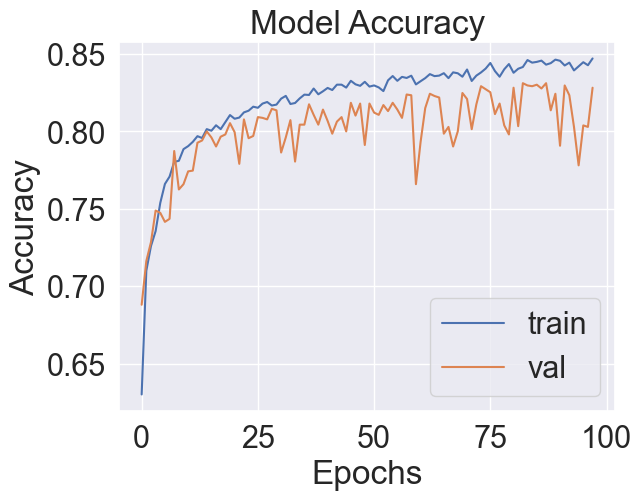

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [33]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 1s 9ms/step - loss: 0.3576 - accuracy: 0.8331


[0.3575848639011383, 0.8331143260002136]

In [34]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 16ms/step


2022-12-31 15:42:59.026496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

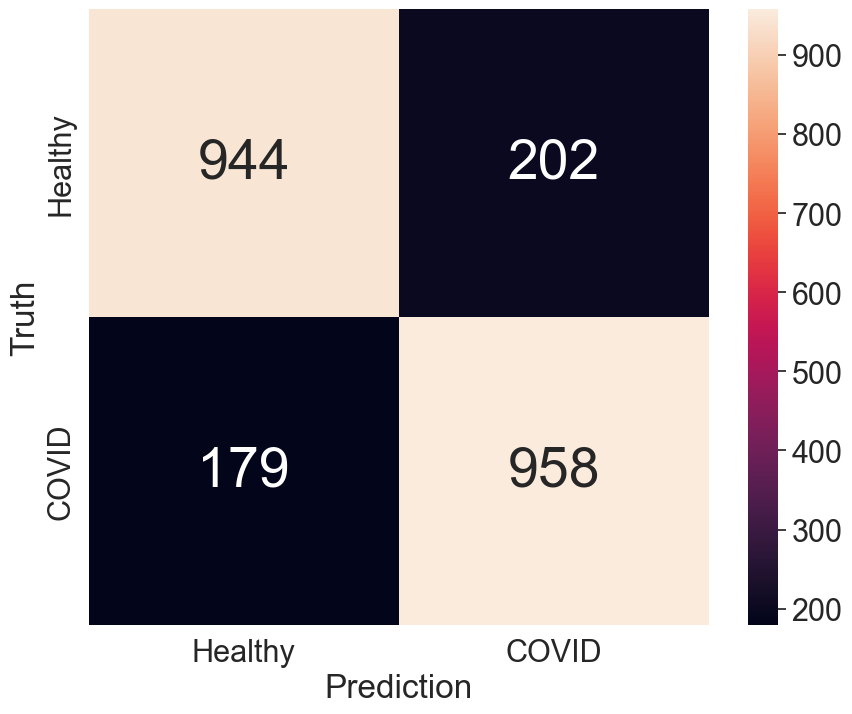

tf.Tensor(
[[944 202]
 [179 958]], shape=(2, 2), dtype=int32)


In [35]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [36]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

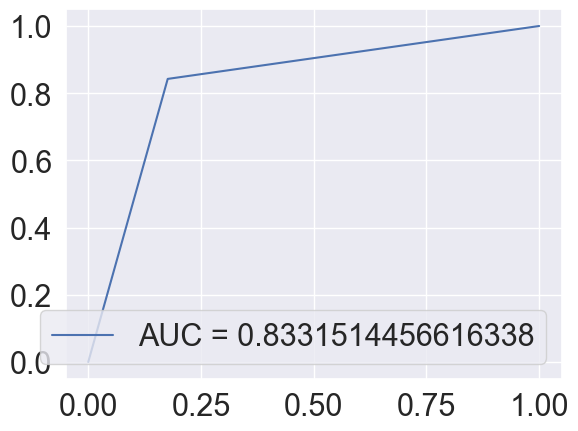

In [37]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()